# **Import libraries**

In [1]:
## Import commands of libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

# **Load the dataset**

In [2]:
import openpyxl

# Load the Excel workbook
workbook = openpyxl.load_workbook('Sales.xlsx')

# Create an empty list to hold the DataFrames
dfs = []

# Loop through all the sheets in the workbook
for sheet in workbook:
    # Load the sheet into a DataFrame and append it to the list
    dfs.append(pd.read_excel('Sales.xlsx', sheet_name=sheet.title))

# Concatenate the DataFrames vertically
data = pd.concat(dfs, axis=0)

The code you provided loads an Excel workbook using the openpyxl library and reads each sheet into a separate pandas DataFrame using the pd.read_excel() function. The DataFrames are then concatenated vertically using pd.concat().

This code assumes that the Excel workbook named "Sales.xlsx" is located in the same directory as the Python script. If the workbook is located elsewhere, you will need to provide the full path to the workbook file.

Once you have loaded the data into a pandas DataFrame, you can perform various operations on it, such as filtering, aggregating, and visualizing the data.

Note that this code requires the openpyxl and pandas libraries to be installed. If you don't have these libraries installed, you can install them using pip:

pip install openpyxl pandas


In [3]:
data

,TANGGAL,TOTAL,KUE SUS,BIKANGDOANG,DONUT COKLAT,PUDDING,RESOLES,ROTI KEJU,ROTI AYAM,BLUDER,SIRAM COKLAT,APANG PARANGGI
0,2022-01-04,3508450,300,27,38,13,28,2,2,30,45,19
1,2022-01-05,4667997,400,13,44,15,42,1,1,40,110,29
2,2022-01-06,5251515,410,2,83,30,92,1,1,35,76,10
3,2022-01-07,5745135,350,14,57,29,30,3,2,44,108,7
4,2022-01-08,6465465,400,17,46,27,29,3,3,34,100,24
...,...,...,...,...,...,...,...,...,...,...,...,...
25,2022-04-26,7706543,476,13,55,20,60,2,2,66,68,18
26,2022-04-27,5462686,400,11,32,10,30,1,2,36,30,15
27,2022-04-28,3989886,300,5,30,1,24,1,2,20,15,3
28,2022-04-29,3499879,340,2,30,0,20,2,2,25,19,5


In [4]:
## check dataset dimension
data.shape

(116, 12)

In [5]:
#3 check dataset columns
data.columns

Index(['TANGGAL', 'TOTAL', 'KUE SUS', 'BIKANGDOANG', 'DONUT COKLAT', 'PUDDING',
       'RESOLES', 'ROTI KEJU', 'ROTI AYAM', 'BLUDER', 'SIRAM COKLAT',
       'APANG PARANGGI'],
      dtype='object')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116 entries, 0 to 29
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   TANGGAL         116 non-null    datetime64[ns]
 1   TOTAL           116 non-null    int64         
 2   KUE SUS         116 non-null    int64         
 3   BIKANGDOANG     116 non-null    int64         
 4   DONUT COKLAT    116 non-null    int64         
 5   PUDDING         116 non-null    int64         
 6   RESOLES         116 non-null    int64         
 7   ROTI KEJU       116 non-null    int64         
 8   ROTI AYAM       116 non-null    int64         
 9   BLUDER          116 non-null    int64         
 10  SIRAM COKLAT    116 non-null    int64         
 11  APANG PARANGGI  116 non-null    int64         
dtypes: datetime64[ns](1), int64(11)
memory usage: 11.8 KB


In [7]:
# Set the 'TANGGAL' column as the index
data.set_index('TANGGAL', inplace=True)

In [8]:
data.head()

,TOTAL,KUE SUS,BIKANGDOANG,DONUT COKLAT,PUDDING,RESOLES,ROTI KEJU,ROTI AYAM,BLUDER,SIRAM COKLAT,APANG PARANGGI
TANGGAL,,,,,,,,,,,
2022-01-04,3508450,300,27,38,13,28,2,2,30,45,19
2022-01-05,4667997,400,13,44,15,42,1,1,40,110,29
2022-01-06,5251515,410,2,83,30,92,1,1,35,76,10
2022-01-07,5745135,350,14,57,29,30,3,2,44,108,7
2022-01-08,6465465,400,17,46,27,29,3,3,34,100,24


In [9]:
# Select the variables to use for the model
variables = ['KUE SUS', 'BIKANGDOANG', 'DONUT COKLAT', 'PUDDING',
       'RESOLES', 'ROTI KEJU', 'ROTI AYAM', 'BLUDER', 'SIRAM COKLAT',
       'APANG PARANGGI']

In [10]:
# Fill any missing values with the mean of each variable
data[variables] = data[variables].fillna(data[variables].mean())

In [11]:
# Create a function to convert the time series data to a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(f'{data.columns[j]}(t-{i})') for j in range(n_vars)]
    # Output sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(f'{data.columns[j]}(t)') for j in range(n_vars)]
        else:
            names += [(f'{data.columns[j]}(t+{i})') for j in range(n_vars)]
    # Combine the input and output sequences
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

This code defines a function series_to_supervised() that converts a time series dataset into a supervised learning problem suitable for use with machine learning algorithms.

The function takes the following arguments:

data: the time series dataset as a pandas DataFrame or a list of lists.
n_in: the number of lag observations as input (default=1).
n_out: the number of future observations as output (default=1).
dropnan: a Boolean indicating whether to drop rows with NaN values (default=True).
The function works by shifting the original dataset n_in steps back in time to create a new DataFrame where each row represents the input sequence for a single time step. It also shifts the dataset n_out steps forward in time to create the corresponding output sequence for each input sequence. The resulting DataFrame has columns for each lagged input feature and each future output feature.

The function returns the transformed DataFrame.

Note that this code assumes that the time series data is already in a pandas DataFrame or a list of lists, and that the column names in the DataFrame represent the features in the dataset. If your data is not in this format, you will need to modify the function accordingly.

In [12]:
## can change time stamp from here
time_steps=10

# Convert the time series data to a supervised learning problem
data_supervised = series_to_supervised(data[variables], n_in=time_steps, n_out=1)

In [41]:
train_data

,KUE SUS(t-10),BIKANGDOANG(t-10),DONUT COKLAT(t-10),PUDDING(t-10),RESOLES(t-10),ROTI KEJU(t-10),ROTI AYAM(t-10),BLUDER(t-10),SIRAM COKLAT(t-10),APANG PARANGGI(t-10),...,KUE SUS(t),BIKANGDOANG(t),DONUT COKLAT(t),PUDDING(t),RESOLES(t),ROTI KEJU(t),ROTI AYAM(t),BLUDER(t),SIRAM COKLAT(t),APANG PARANGGI(t)
TANGGAL,,,,,,,,,,,,,,,,,,,,,
2022-01-14,300.0,27.0,38.0,13.0,28.0,2.0,2.0,30.0,45.0,19.0,...,400,16,26,15,29,1,1,15,100,13
2022-01-15,400.0,13.0,44.0,15.0,42.0,1.0,1.0,40.0,110.0,29.0,...,420,19,50,18,19,3,2,100,50,13
2022-01-16,410.0,2.0,83.0,30.0,92.0,1.0,1.0,35.0,76.0,10.0,...,378,15,49,25,29,3,2,18,35,5
2022-01-17,350.0,14.0,57.0,29.0,30.0,3.0,2.0,44.0,108.0,7.0,...,346,8,41,8,28,3,2,11,13,7
2022-01-18,400.0,17.0,46.0,27.0,29.0,3.0,3.0,34.0,100.0,24.0,...,228,7,11,4,16,2,1,22,45,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-04,376.0,10.0,45.0,13.0,28.0,1.0,1.0,20.0,36.0,21.0,...,400,18,50,6,25,1,2,39,45,20
2022-04-05,476.0,13.0,55.0,20.0,60.0,2.0,2.0,66.0,68.0,18.0,...,400,16,40,12,30,2,2,45,33,13
2022-04-06,400.0,11.0,32.0,10.0,30.0,1.0,2.0,36.0,30.0,15.0,...,500,20,76,15,45,0,2,53,56,18


In [13]:
# Split the data into training and validation sets
train_size = int(len(data_supervised) * 0.8)
train_data = data_supervised[:train_size]
val_data = data_supervised[train_size:]

# Scale the data using the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data)
val_data_scaled = scaler.transform(val_data)

# Split the data into input and output variables
train_X, train_y = train_data_scaled[:, :-len(variables)], train_data_scaled[:, -len(variables):]
val_X, val_y = val_data_scaled[:, :-len(variables)], val_data_scaled[:, -len(variables):]
# Reshape the input data to 3D arrays
train_X = train_X.reshape((train_X.shape[0], time_steps, len(variables)))
val_X = val_X.reshape((val_X.shape[0], time_steps, len(variables)))

# **ANN with LSTM layer**

In [14]:
#  Build the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(64, activation='relu', input_shape=(time_steps, len(variables))))
model.add(tf.keras.layers.Dense(len(variables)))
model.compile(loss='mse', optimizer='adam')

# Train the model
history = model.fit(train_X, train_y, epochs=100, batch_size=5,validation_data=(val_X, val_y), verbose=1)

Epoch 1/100
17/17 [==============================] - 2s 26ms/step - loss: 0.1085 - val_loss: 0.0488
Epoch 2/100
17/17 [==============================] - 0s 8ms/step - loss: 0.0469 - val_loss: 0.0306
Epoch 3/100
17/17 [==============================] - 0s 9ms/step - loss: 0.0411 - val_loss: 0.0292
Epoch 4/100
17/17 [==============================] - 0s 8ms/step - loss: 0.0393 - val_loss: 0.0290
Epoch 5/100
17/17 [==============================] - 0s 10ms/step - loss: 0.0378 - val_loss: 0.0279
Epoch 6/100
17/17 [==============================] - 0s 9ms/step - loss: 0.0379 - val_loss: 0.0273
Epoch 7/100
17/17 [==============================] - 0s 9ms/step - loss: 0.0373 - val_loss: 0.0264
Epoch 8/100
17/17 [==============================] - 0s 9ms/step - loss: 0.0366 - val_loss: 0.0272
Epoch 9/100
17/17 [==============================] - 0s 9ms/step - loss: 0.0363 - val_loss: 0.0256
Epoch 10/100
17/17 [==============================] - 0s 9ms/step - loss: 0.0356 - val_loss: 0.0252
Epoch 1

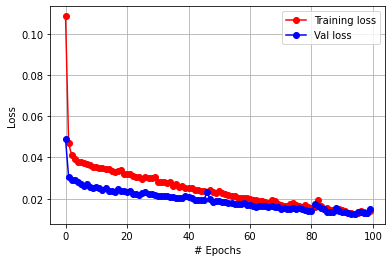

In [15]:
plt.plot(range(100), history.history['loss'], 'ro-', label="Training loss")
plt.plot(range(100), history.history['val_loss'], 'bo-', label="Val loss")
plt.xlabel("# Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

# **model prediction on Validation Data**

1/1 [==============================] - 0s 204ms/step
RMSE: [0.13303025 0.12751488 0.1293053  0.14596529 0.09468255 0.19161745
 0.05409836 0.05188178 0.0249062  0.16922628]


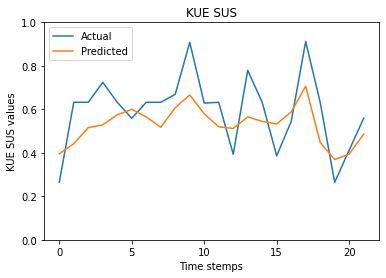

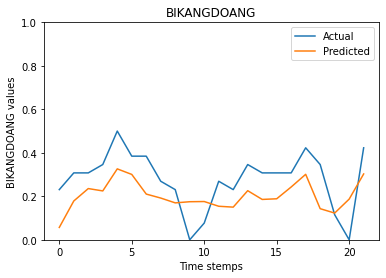

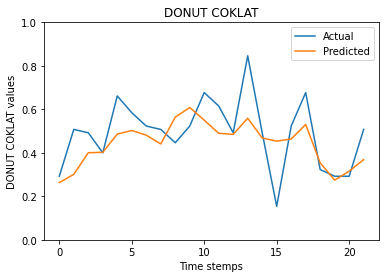

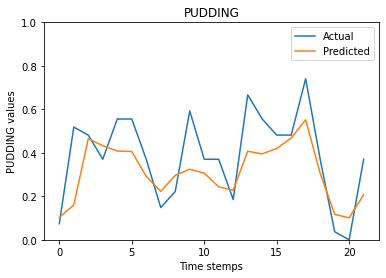

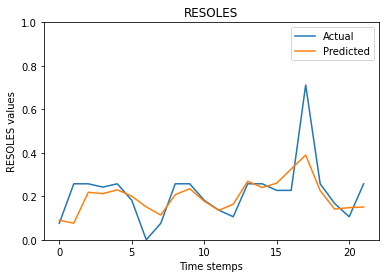

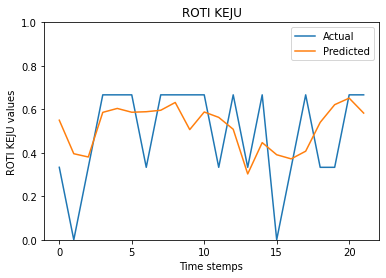

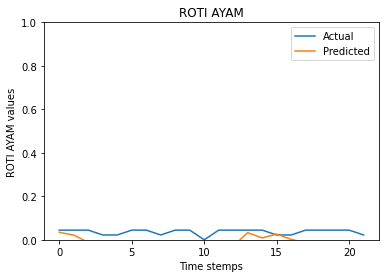

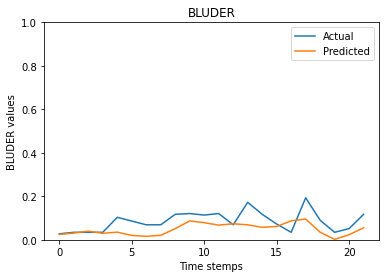

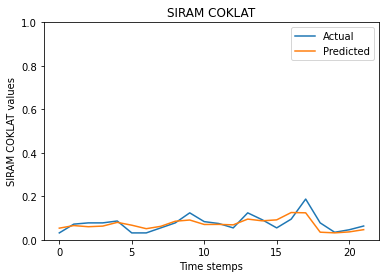

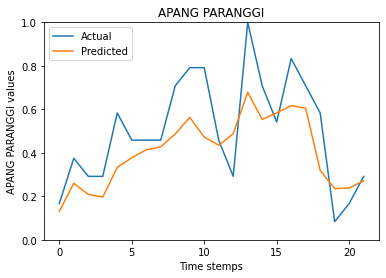

In [16]:
#  Make forecasts
# Predict the next time step for the validation data
val_pred = model.predict(val_X)


# Calculate the root mean squared error (RMSE) for each variable
rmse = np.sqrt(np.mean(np.square(val_y - val_pred), axis=0))
print(f'RMSE: {rmse}')

# Plot the predicted vs. actual values for each variable
for i, variable in enumerate(variables):
    plt.figure()
    plt.plot(val_y[:, i], label='Actual')
    plt.plot(val_pred[:, i], label='Predicted')
    plt.title(variable)
    plt.xlabel("Time stemps")
    plt.ylabel(variable+" values")
    plt.ylim(0,1)
    plt.legend()
    plt.show()

# **Future Forcasting**

In [17]:
# Define the number of time steps in the input sequence
look_back = model.input_shape[1]
# Copy the last look_back days of historical data to use as a starting point for the forecast
current_input = val_X[-look_back:, :, :]
print(current_input.shape)

    
# Generate a forecast for the next days
forcasts= model.predict(current_input)

# Update the input sequence with the new forecast
current_input = np.concatenate([current_input[1:, :, :], forcasts[np.newaxis, :, :]], axis=0)

(10, 10, 10)
1/1 [==============================] - 0s 24ms/step


In [18]:
forcasts

array([[ 0.5121424 ,  0.15024026,  0.4848787 ,  0.22823483,  0.16376607,
         0.50830746, -0.02878034,  0.0736547 ,  0.06875052,  0.48767075],
       [ 0.56506443,  0.225875  ,  0.5591462 ,  0.40739635,  0.2693214 ,
         0.30288523,  0.03292119,  0.06881654,  0.09521985,  0.67805266],
       [ 0.54446894,  0.18565495,  0.4683116 ,  0.39523646,  0.24048436,
         0.4469287 ,  0.00870773,  0.05746754,  0.08724658,  0.55361354],
       [ 0.53274703,  0.188645  ,  0.45365047,  0.42011413,  0.2603563 ,
         0.3911661 ,  0.02625881,  0.06131705,  0.09169392,  0.5838163 ],
       [ 0.5877255 ,  0.24295008,  0.46356836,  0.4683402 ,  0.32558998,
         0.37217093,  0.00186749,  0.08706979,  0.12542136,  0.61693496],
       [ 0.70633686,  0.30112273,  0.5304182 ,  0.5517543 ,  0.38983005,
         0.40748605, -0.0125264 ,  0.09557437,  0.12410589,  0.6052627 ],
       [ 0.44824436,  0.14310205,  0.35388246,  0.30571666,  0.22564095,
         0.53992945, -0.01728389,  0.03474046

In [19]:
# Get the dates for the original data
dates = data.index[-len(val_y):]
# Create a new array of dates for the forecast
forecast_dates = pd.date_range(start=dates[-1], periods=len(forcasts)+1, freq='D')[1:]

In [20]:
dates

DatetimeIndex(['2022-04-09', '2022-04-10', '2022-04-11', '2022-04-12',
               '2022-04-13', '2022-04-14', '2022-04-15', '2022-04-16',
               '2022-04-17', '2022-04-18', '2022-04-19', '2022-04-20',
               '2022-04-21', '2022-04-22', '2022-04-23', '2022-04-24',
               '2022-04-25', '2022-04-26', '2022-04-27', '2022-04-28',
               '2022-04-29', '2022-04-30'],
              dtype='datetime64[ns]', name='TANGGAL', freq=None)

In [21]:
forecast_dates

DatetimeIndex(['2022-05-01', '2022-05-02', '2022-05-03', '2022-05-04',
               '2022-05-05', '2022-05-06', '2022-05-07', '2022-05-08',
               '2022-05-09', '2022-05-10'],
              dtype='datetime64[ns]', freq='D')

In [36]:
forecast_df = pd.DataFrame(forcasts, columns=['Forecast' + str(i+1) for i in range(forcasts.shape[1])])
#forecast_df['Date'] = forecast_dates
forecast_df

,Forecast1,Forecast2,Forecast3,Forecast4,Forecast5,Forecast6,Forecast7,Forecast8,Forecast9,Forecast10
0,0.512142,0.150240,0.484879,0.228235,0.163766,0.508307,-0.028780,0.073655,0.068751,0.487671
1,0.565064,0.225875,0.559146,0.407396,0.269321,0.302885,0.032921,0.068817,0.095220,0.678053
2,0.544469,0.185655,0.468312,0.395236,0.240484,0.446929,0.008708,0.057468,0.087247,0.553614
3,0.532747,0.188645,0.453650,0.420114,0.260356,0.391166,0.026259,0.061317,0.091694,0.583816
4,0.587726,0.242950,0.463568,0.468340,0.325590,0.372171,0.001867,0.087070,0.125421,0.616935
5,0.706337,0.301123,0.530418,0.551754,0.389830,0.407486,-0.012526,0.095574,0.124106,0.605263
6,0.448244,0.143102,0.353882,0.305717,0.225641,0.539929,-0.017284,0.034740,0.034980,0.319370
7,0.369078,0.122988,0.274254,0.117108,0.141329,0.621425,-0.043340,0.001945,0.031915,0.235483
8,0.394178,0.187126,0.315562,0.100860,0.147928,0.651498,-0.030255,0.023610,0.036302,0.237977
9,0.485808,0.302794,0.368835,0.207461,0.150873,0.582794,-0.011891,0.055157,0.046624,0.271550


In [42]:
forecast_df.columns

Index(['Forecast1', 'Forecast2', 'Forecast3', 'Forecast4', 'Forecast5',
       'Forecast6', 'Forecast7', 'Forecast8', 'Forecast9', 'Forecast10'],
      dtype='object')

In [ ]:
####################################################################################

In [43]:
arr=forecast_df.values

In [46]:
arr=np.resize(arr,(10,110))

In [48]:
values_df=pd.DataFrame(scaler.inverse_transform(arr))

In [50]:
values_df=values_df.iloc[:,0:10]

In [51]:
values_df.columns=forecast_df.columns

In [52]:
values_df['Date'] = forecast_dates

In [54]:
values_df.index=forecast_dates

In [55]:
values_df

,Forecast1,Forecast2,Forecast3,Forecast4,Forecast5,Forecast6,Forecast7,Forecast8,Forecast9,Forecast10,Date
2022-05-01,367.302734,6.408649,45.911263,6.847045,25.937519,1.524922,-1.295115,29.507172,26.856432,14.654781,2022-05-01
2022-05-02,381.697510,9.131500,51.258530,12.221890,34.276390,0.908656,1.481454,28.094431,36.041290,19.985474,2022-05-02
2022-05-03,376.095551,7.683578,44.718437,11.857094,31.998262,1.340786,0.391848,24.780523,33.274563,16.501179,2022-05-03
2022-05-04,372.907196,7.791220,43.662834,12.603424,33.568146,1.173498,1.181646,25.904579,34.817791,17.346855,2022-05-04
2022-05-05,387.861328,9.746203,44.376923,14.050205,38.721607,1.116513,0.084037,33.424381,46.521214,18.274178,2022-05-05
2022-05-06,420.123627,11.840419,49.190113,16.552629,43.796577,1.222458,-0.563688,35.907715,46.064743,17.947355,2022-05-06
2022-05-07,349.922485,6.151674,36.479538,9.171500,30.825634,1.619788,-0.777775,18.144215,15.138195,9.942354,2022-05-07
2022-05-08,328.389313,5.427562,30.746258,3.513252,24.165018,1.864274,-1.950302,8.567899,14.074399,7.593536,2022-05-08
2022-05-09,335.216339,7.736533,33.720444,3.025795,24.686277,1.954495,-1.361492,14.894007,15.596805,7.663345,2022-05-09
2022-05-10,360.139771,11.900595,37.556141,6.223834,24.918949,1.748383,-0.535100,24.105947,19.178576,8.603400,2022-05-10


In [ ]:
##########################################################################################################

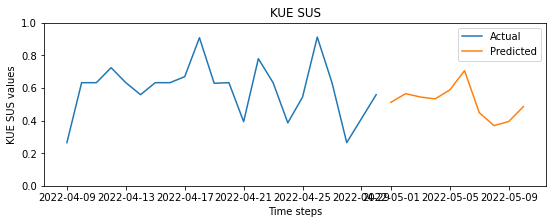

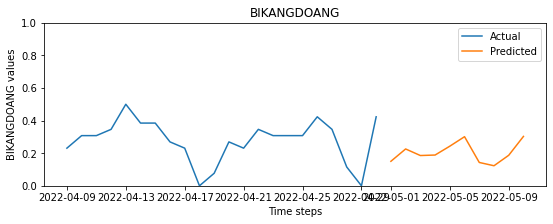

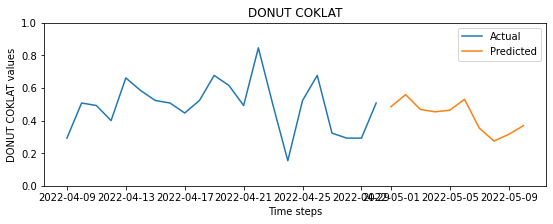

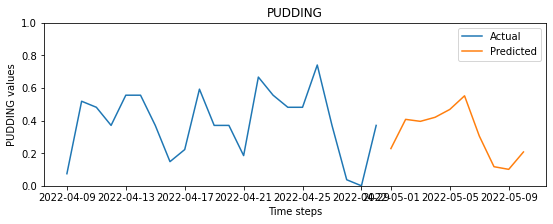

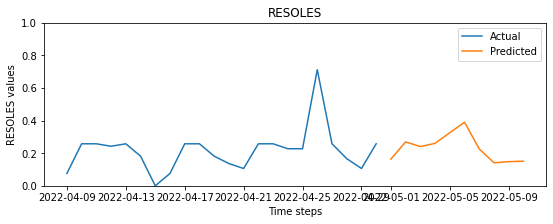

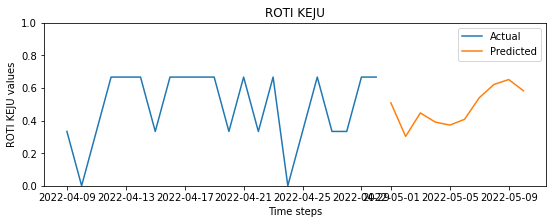

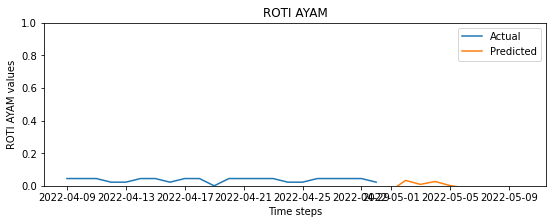

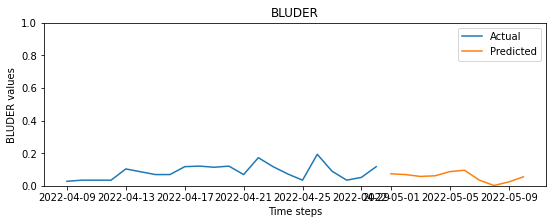

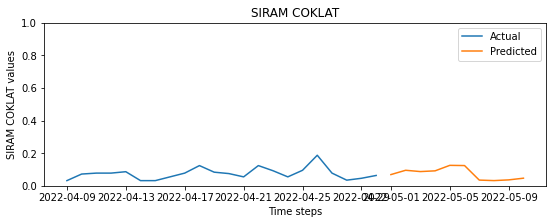

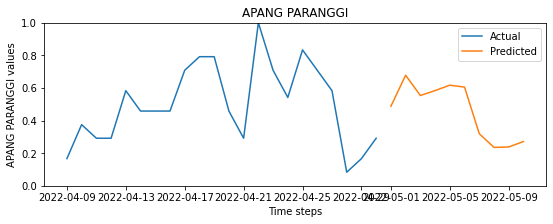

In [23]:
# Plot the predicted vs. actual values for each variable
fig_size = (9, 3)  # Set the figure size
for i, variable in enumerate(variables):
    plt.figure(figsize=fig_size)  # Set the figure size
    plt.plot(dates,val_y[:, i], label='Actual')
    plt.plot(forecast_dates,np.array(forcasts)[:, i], label='Predicted')
    plt.title(variable)
    # set y-axis limits
    plt.ylim(0, 1)
    plt.xlabel("Time steps")
    plt.ylabel(variable+" values")
    plt.legend()
    plt.show()
